In [64]:
import os, time, h5py, platform, json, sys
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
sys.path.append(r"C:\Users\Gerwin\Documents\Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm, trange
from scipy.optimize import minimize
from termcolor import cprint
from glob import glob
from Common import common
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
# %config InlineBackend.figure_format='retina'

sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch\experiment")
from data_cache import dataCacheProxy

In [52]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Solve for the position of $N$ particles in the trap

In [66]:
savepath = r"S:\Gerwin\Electron on helium\Papers\2017 - Circuit QED with a single electron on helium\Supplement\simulation"

Sweeping resonator from 0.60 V to 0.60 V


61it [08:17,  8.56s/it]


Number of unbounded electrons = 0


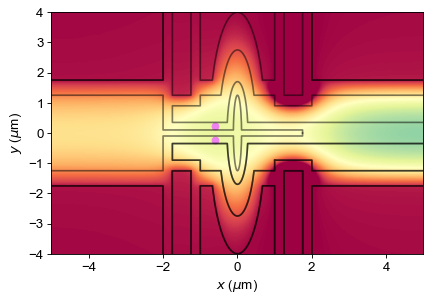

In [44]:
from TrapAnalysis.solve_eom import FullSolver

#settings_file = r"/Users/gkoolstra/Desktop"
settings_file = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6"
#settings_file += r"/With L3 etch - just trap/settings.json"
settings_file += r"\With L3 etch - just trap\settings.json"
fs = FullSolver(settings_file)

x = 0.380

mu_guess = -0.265
def f_mu(mu):
    return -1.755 - 7*mu

Vtrap = np.linspace(0.20, 0.40, 151) #np.array([0.2975])
Vrg = np.linspace(-1/2.45 * (Vtrap[0] - f_mu(mu_guess))- x, 
                  -1/2.45 * (Vtrap[-1] -f_mu(mu_guess))- x, len(Vtrap))
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))
Vcg = None

N_e = 2

electron_positions = fs.get_trap_electron_positions(Vres, Vtrap, Vrg, Vtg, N=N_e)
tex = electron_positions[:, ::2]
tey = electron_positions[:, 1::2]

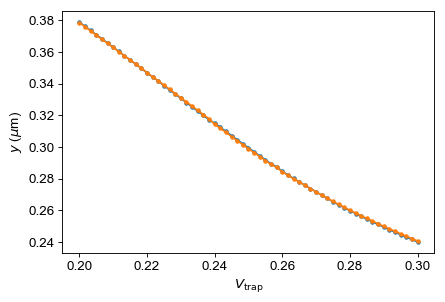

In [45]:
for i in range(N_e):
    plt.plot(Vtrap, abs(tey[:,i]) * 1E6, '.-')
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("$y$ ($\mu$m)")

# Solve the equations of motion using `TrapSolver`

To solve the equations of motion we have to initialize the FEM data at the start of the voltage sweeps

In [46]:
fs.set_rf_interpolator()
fs.set_dc_interpolator(Vres[0], Vtrap[0], Vrg[0], Vtg[0])

In [47]:
fs.resonator_constants['f0'] = 6.405E9
fs.resonator_constants['Q'] = 1.8E4
fs.resonator_constants['Z0'] = 90.0

all_ordered_freqs = list()
EVals, EVecs = [], []

for k in trange(np.shape(tex)[0]):
#     fs.set_dc_interpolator(Vres[k], Vtrap[k], Vrg[k], Vtg[k])
    fs.update_dc_interpolator(Vres[k], Vtrap[k], Vrg[k], Vtg[k])
    LHS = fs.setup_eom(anneal.xy2r(tex[k, :], tey[k, :]))
    evals, evecs = fs.solve_eom(LHS)
    EVals.append(evals); EVecs.append(evecs)
    
    cavity_contributions = evecs[0, :]
    largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
    
    all_ordered_freqs.append(np.sqrt(evals[largest_cavity_contributions])/(2*np.pi*1E9))
    
EVals = np.array(EVals); EVecs = np.array(EVecs)
all_ordered_freqs=np.array(all_ordered_freqs)

100%|██████████| 61/61 [08:08<00:00,  8.28s/it]


In [48]:
from TrapAnalysis.resonator_analysis import get_resonator_constants
from TrapAnalysis.trap_analysis import get_constants
constants = get_resonator_constants().copy()
constants.update(get_constants())

constants['f0'] = 6.405E9
constants['Z0'] = 90
constants['Q'] = 1E4
print(constants)

def get_coupling(E0):
    """
    E0 is the electric field in the y-direction when +-0.5 V is applied to the left and right pin of the 
    resonator, respectively. This _must_ be the differential mode of the resonator.
    """
    return 1/(2*np.pi) * constants['e'] * E0/2. * np.sqrt(2*np.pi*constants['f0']*constants['Z0']/constants['m_e'])

couplings = list()
for texs, teys in zip(tex, tey):
    couplings.append(get_coupling(fs.Ey(texs, teys)))
    
couplings = np.mean(np.array(couplings), axis=1)

{'f0': 6405000000.0, 'Z0': 90, 'Q': 10000.0, 'P': -100, 'e': 1.602e-19, 'm_e': 9.11e-31, 'eps0': 8.85e-12}


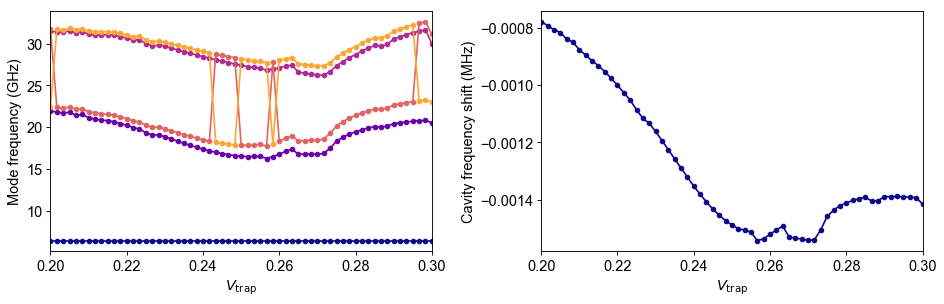

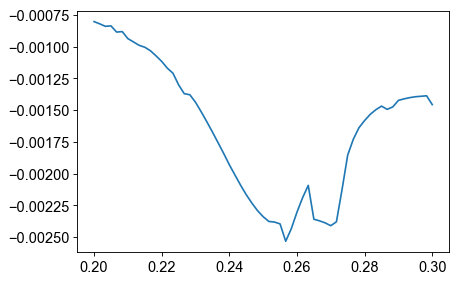

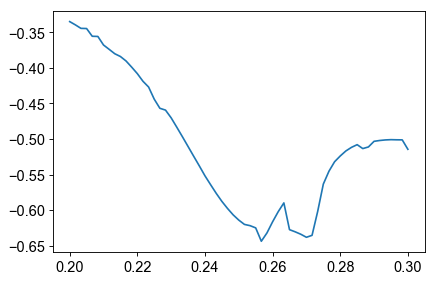

In [49]:
from TrapAnalysis import single_electron as se

mag_signal, phase_signal = list(), list()
for i, g in enumerate(couplings):
    magnitude, phase = se.s21(kappa_tot=fs.resonator_constants['f0']/fs.resonator_constants['Q'], 
                              g=couplings[i], 
                              f_cavity=fs.resonator_constants['f0'], 
                              f_probe=fs.resonator_constants['f0'], 
                              f_electron=all_ordered_freqs[i, 1] * 1E9, 
                              gamma=200E6)
    mag_signal.append(20 * np.log10(magnitude))
    phase_signal.append(phase * 180/np.pi)

mag_signal = np.array(mag_signal)
phase_signal = np.array(phase_signal)
    
fig = plt.figure(figsize=(12.,4.))
common.configure_axes(13)
plt.subplot(121)
for k in range(2*N_e+1):
    plt.plot(Vtrap, all_ordered_freqs[:, k], '-o', 
             color=common.rgb(k, 2*N_e+1) ,ms=4)
    
# plt.ylim(0., 30.)
plt.xlim(min(Vtrap), max(Vtrap))
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("Mode frequency (GHz)")

plt.subplot(122)
plt.plot(Vtrap, (all_ordered_freqs[:, 0] * 1E9 - fs.resonator_constants['f0'])/1E6, '-o', 
             color=common.rgb(0, 2*N_e+1) ,ms=4)
plt.xlim(min(Vtrap), max(Vtrap))
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("Cavity frequency shift (MHz)")

fig.tight_layout()

plt.figure()
plt.plot(Vtrap, mag_signal)

plt.figure()
plt.plot(Vtrap, phase_signal)

In [67]:
h5_filename = os.path.join(savepath, 'classical_mode_solver_%d_electrons.h5' % N_e )

if os.path.exists(h5_filename):
    os.remove(h5_filename)

print("%s ..."%h5_filename)
myfile = dataCacheProxy(file_path=h5_filename)
myfile.post("Vres", Vres)
myfile.post("Vtrap", Vtrap)
myfile.post("Vrg", Vrg)
myfile.post("Vtg", Vtg)
myfile.post("phases", phase_signal)
myfile.post("mags", mag_signal)
myfile.post("g", couplings)
myfile.post("N_e", N_e)
myfile.post("xi", tex)
myfile.post("yi", tey)
myfile.post("ordered_eigenfreqs", all_ordered_freqs)

S:\Gerwin\Electron on helium\Papers\2017 - Circuit QED with a single electron on helium\Supplement\simulation\classical_mode_solver_2_electrons.h5 ...


In [68]:
thisfile = dataCacheProxy(file_path=h5_filename)
print(thisfile.get('Vtrap')[0])

[ 0.2         0.20166667  0.20333333  0.205       0.20666667  0.20833333
  0.21        0.21166667  0.21333333  0.215       0.21666667  0.21833333
  0.22        0.22166667  0.22333333  0.225       0.22666667  0.22833333
  0.23        0.23166667  0.23333333  0.235       0.23666667  0.23833333
  0.24        0.24166667  0.24333333  0.245       0.24666667  0.24833333
  0.25        0.25166667  0.25333333  0.255       0.25666667  0.25833333
  0.26        0.26166667  0.26333333  0.265       0.26666667  0.26833333
  0.27        0.27166667  0.27333333  0.275       0.27666667  0.27833333
  0.28        0.28166667  0.28333333  0.285       0.28666667  0.28833333
  0.29        0.29166667  0.29333333  0.295       0.29666667  0.29833333
  0.3       ]


It seems `linalg.eig` doesn't preserve the order of columns, but it _does_ preserve the rows. This means that the first row in `EVecs` contains the cavity contributions and that the next rows are labeled from $x_1$ through $x_N$ and then $y_1$ through $y_N$, where $N$ is the number of electrons.

In `largest_cavity_contribitions` the first index contains the column number of `EVecs` that is related to the cavity mode. To be more explicit `cavity_eigenmode = EVecs[:, cavity_contributions[0]]`. We can also look at it's eigenvalue, or frequency and confirm that it is close to the value we gave it:

In [28]:
idx = common.find_nearest(Vtrap, 0.280)

cf = all_ordered_freqs[idx, 0]
ef = all_ordered_freqs[idx, 1]
g = 5E6

print("Cavity shift is %.0f kHz" % ((cf - fs.resonator_constants['f0']/1E9)*1E6))
print("Dispersive shift from strongest mode should be %.0f kHz" \
      % -(g**2/(ef - fs.resonator_constants['f0']) * 1E-3))

Cavity shift is -5 kHz
Dispersive shift from strongest mode should be 4 kHz


In [29]:
xeval = np.linspace(-4, 4, 501)
yeval = np.linspace(-4, 4, 251)
xinterp, yinterp = np.meshgrid(xeval, yeval)

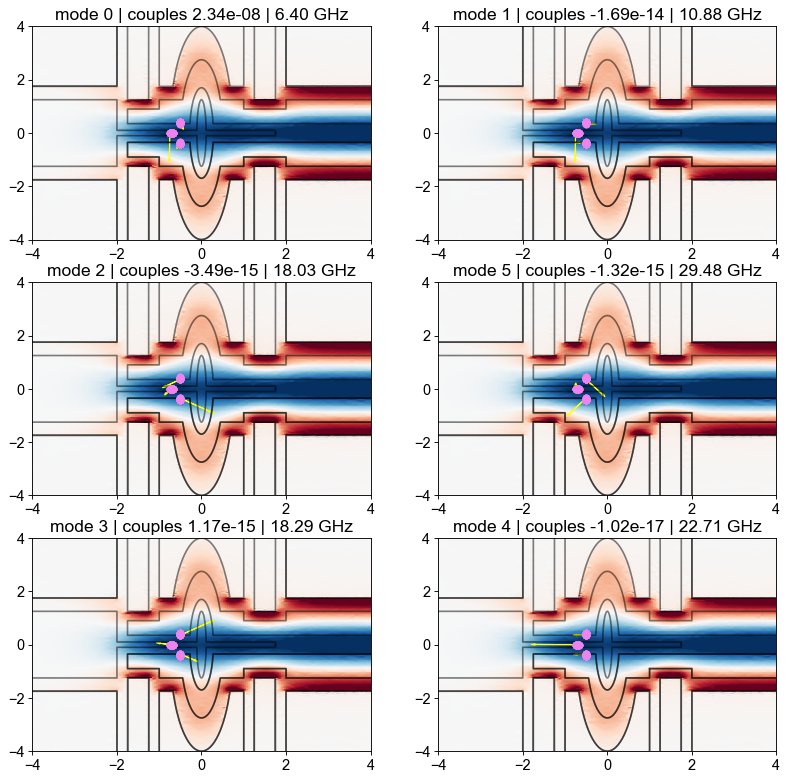

In [30]:
plt.figure(figsize=(2*6., 3*4.))

for k in range(min([2*N_e + 1, 6])):
    cavity_contributions = EVecs[idx, 0, :]
    largest_cavity_contributions = np.argsort(np.abs(cavity_contributions))[::-1]
    mode_nr = largest_cavity_contributions[k]
    amp = EVecs[idx, 1:, mode_nr]
    plt.subplot(3, 2, k+1)
    plt.pcolormesh(xinterp, yinterp, fs.Ey(xinterp * 1E-6, yinterp * 1E-6), 
                  cmap=plt.cm.RdBu, vmin=-2E5 , vmax=2E5)
    anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                     color="k", alpha=0.5)
    #plt.plot(tex[idx, :] * 1E6, tey[idx, :] * 1E6, 'o', color='violet', alpha=1.0)
    plt.plot(tex[:, :] * 1E6, tey[:, :] * 1E6, 'o', color='violet', alpha=1.0)
    for m in range(N_e):
        plt.arrow(x=tex[idx, m] * 1E6, y=tey[idx, m] * 1E6, dx=amp[m], 
                  dy=amp[N_e+m] * 1, head_width=0.05, head_length=0.1, fc='yellow', ec='yellow')
    plt.title("mode %d | couples %.2e | %.2f GHz" % (mode_nr, EVecs[idx, 0, mode_nr], np.sqrt(EVals[idx, mode_nr])/(2*np.pi*1E9)))
    plt.xlim(min(xeval), max(xeval))
    plt.ylim(min(yeval), max(yeval))
#     plt.colorbar()

# Check the data

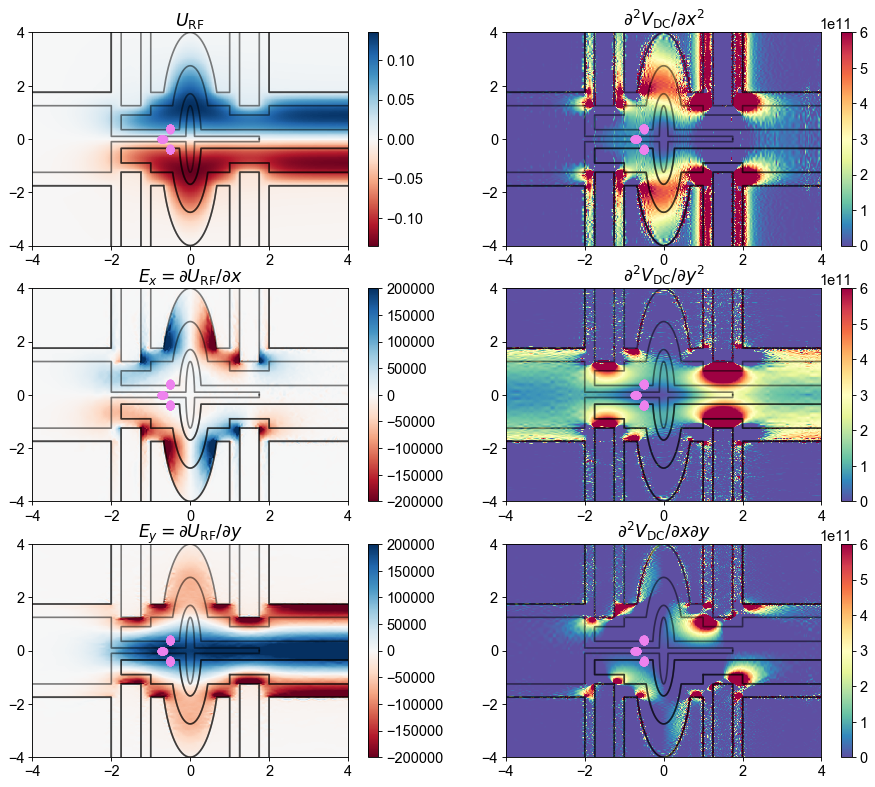

In [31]:
xeval = np.linspace(-4, 4, 501)
yeval = np.linspace(-4, 4, 251)
xinterp, yinterp = np.meshgrid(xeval, yeval)

plt.figure(figsize=(2*7.,3*4.))
plt.subplot(321)
plt.pcolormesh(xinterp, yinterp, fs.rf_interpolator.ev(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$U_\mathrm{RF}$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(323)
plt.pcolormesh(xinterp, yinterp, fs.Ex(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu, vmin=-2E5, vmax=2E5)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$E_x = \partial U_\mathrm{RF}/\partial x$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(325)
plt.pcolormesh(xinterp, yinterp, fs.Ey(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.RdBu, vmin=-2E5, vmax=2E5)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$E_y = \partial U_\mathrm{RF}/\partial y$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(322)
plt.pcolormesh(xinterp, yinterp, fs.curv_xx(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=6E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x^2$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(324)
plt.pcolormesh(xinterp, yinterp, fs.curv_yy(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=6E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial y^2$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

plt.subplot(326)
plt.pcolormesh(xinterp, yinterp, fs.curv_xy(xinterp * 1E-6, yinterp * 1E-6), 
              cmap=plt.cm.Spectral_r, vmin=0, vmax=6E11)
anneal.draw_from_dxf(os.path.join(fs.master_path, "all_electrodes.dxf"), offset=(0E-6, 0E-6),
                                 color="k", alpha=0.5)
plt.plot(tex * 1E6, tey * 1E6, 'o', color='violet', alpha=1.0)
plt.title("$\partial^2 V_\mathrm{DC}/\partial x \partial y$")
plt.xlim(min(xeval), max(xeval))
plt.ylim(min(yeval), max(yeval))
plt.colorbar()

# Retrieve data from different $N_e$ in a single plot

classical_mode_solver_2_electrons.h5


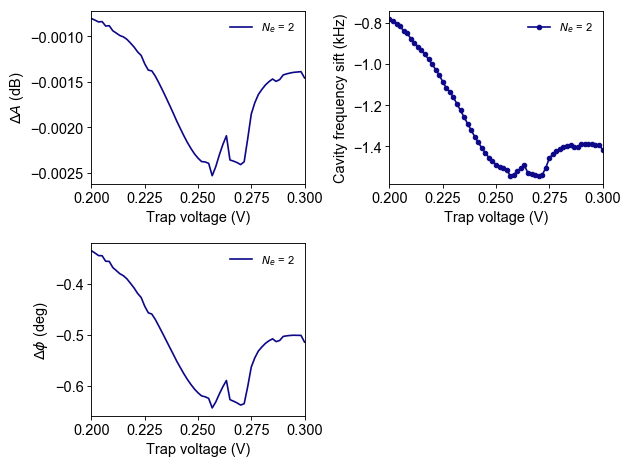

In [92]:
fns = glob(os.path.join(savepath, "*.h5"))

fig = plt.figure(figsize=(8.,6.))
common.configure_axes(13)

for kk, fn in enumerate(fns):
    print(os.path.split(fn)[1])
    thisfile = dataCacheProxy(file_path=fn)
    
    Vtrap = thisfile.get('Vtrap')[0]
    all_ordered_freqs = thisfile.get('ordered_eigenfreqs')[0]
    N_e = thisfile.get("N_e")[0]
    mag_signal = thisfile.get("mags")[0]
    phase_signal = thisfile.get("phases")[0]
    
    plt.subplot(222)
    plt.plot(Vtrap, (all_ordered_freqs[:, 0] * 1E9 - 6.405E9)/1E3, '-o', 
                 color=common.rgb(kk, len(fns)) ,ms=4, label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("Cavity frequency sift (kHz)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)

    plt.subplot(221)
    plt.plot(Vtrap, mag_signal, color=common.rgb(kk, len(fns)), label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("$\Delta A$ (dB)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
    plt.subplot(223)
    plt.plot(Vtrap, phase_signal, color=common.rgb(kk, len(fns)), label='$N_e$ = %d'%N_e)
    plt.xlim(min(Vtrap), max(Vtrap))
    plt.xlabel("Trap voltage (V)")
    plt.ylabel("$\Delta \phi$ (deg)")
    plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
fig.tight_layout()